# July 10, 17-27, 2023: Synthetic dynamical systems, 1D: SINDy discovery

In [1]:
import csv
import os
import pickle
import random
import sys
from os.path import join as pjoin
import numpy as np
import scipy as sp 
import pandas as pd
import pysindy as ps
import sklearn as skl
from scipy.spatial.distance import pdist, cdist, squareform, cosine
from scipy import stats, integrate
import tvb
import networkx as nx
import copy
import matlab.engine
from itertools import product
from tqdm import tqdm
from netrd.distance import ResistancePerturbation, PortraitDivergence, GraphDiffusion, DMeasure

sys.path.append("/usr/local/MATLAB/R2022b/bin/matlab")

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_estimation')
month_dir = f"{proj_dir}/nb/apr23"
bdmodels_dir = f"{proj_dir}/helpers/bdmodels"
networks_dir = f"{proj_dir}/helpers/networks"
results_dir = f"{proj_dir}/results"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# folders
sys.path.insert(0, proj_dir)
import helpers.functions.network_utils as nw_utils
import helpers.functions.plotting_utils as plot_utils
import helpers.functions.time_series_simulation_utils as ts_sim_utils
import helpers.functions.fc_utils as fc_utils

In [2]:
class ARGS(): pass
args = ARGS()

args.SEED = 100
np.random.seed(args.SEED)

## test case

In [3]:
args.dt = 0.1
args.time_end = 10
args.time_span = [0, args.time_end]
args.time = np.arange(0, args.time_end, args.dt)

diff_method = ps.FiniteDifference()

x = 5*np.exp(-args.time)[:, None]
# xdot = np.cos(args.time)
xd = diff_method._differentiate(x, args.time)

assert(np.all(xd - x))

In [4]:
threshold = 0.1
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    # feature_library=ps.FourierLibrary(n_frequencies=5),
    feature_library=ps.PolynomialLibrary(degree=5),
    differentiation_method=ps.FiniteDifference(axis=-2),
)
model.fit(x, args.dt, )
model.print()

x_d = model.predict(x)
x_sim = model.simulate(x[0], args.time, )

(x0)' = -1.001 x0


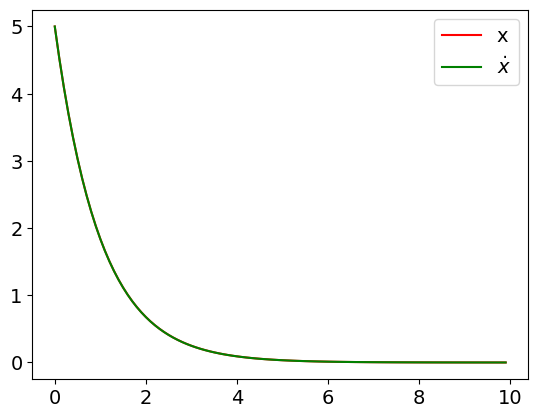

In [5]:
plt.plot(args.time, x, 'r-', label='x')
plt.plot(args.time, x_sim, 'g-', label='$\dot{x}$')
plt.legend()

## linear sde
1 node

$$
\frac{d}{dt} x = - A x + u
$$

### synthetic data

In [6]:
args.num_rois = 1
network = 1 - np.eye(args.num_rois)
# network[0, 1] = 0.0
# network[1, 0] = 0.0
print(network)

eng = matlab.engine.start_matlab()
model_path = f"{bdmodels_dir}"
model = eng.simulate_linear_sde_model

args.num_runs = 50
in_dicts = {
    f"run{idx_run:02}" : None
    for idx_run in range(args.num_runs)
}
out_dicts = copy.deepcopy(in_dicts)

args.dt = 0.1
args.time_end = 10
args.time_span = [0, args.time_end]
args.time = np.arange(0, args.time_end, args.dt)

stimulus = np.array([[1.0]]) #np.array([[1.0], [0.0]])
args.Iamp = 1.0
args.tau = 5.0
args.T = 25.0

in_dict = {}
in_dict['A'] = matlab.double(np.array([[0.75]])) #matlab.double(np.array([[0.5], [0.5]]))
in_dict['B'] = 1.0
in_dict['Iamp'] = args.Iamp
in_dict['tau'] = args.tau
in_dict['T'] = args.T
in_dict['tspan'] = matlab.double(args.time_span) 
in_dict['teval'] = matlab.double(args.time)
in_dict['s'] = matlab.double(stimulus)

for idx_run in tqdm(np.arange(args.num_runs)):
    in_dict['sigma'] = 0.2
    in_dict['x_init'] = 0.0 #matlab.double(np.random.rand(args.num_rois))
    in_dict['randn'] = np.random.normal(
        loc=0.0, 
        scale=1.0, 
        size=(args.num_rois, args.time.size),
    )
    in_dict['W'] = network
    in_dicts[f"run{idx_run:02}"] = copy.deepcopy(in_dict)

    out_dict = ts_sim_utils.simulate(eng, model_path, model, in_dict)

    out_dicts[f"run{idx_run:02}"] = copy.deepcopy(out_dict)

eng.quit()

[[0.]]


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


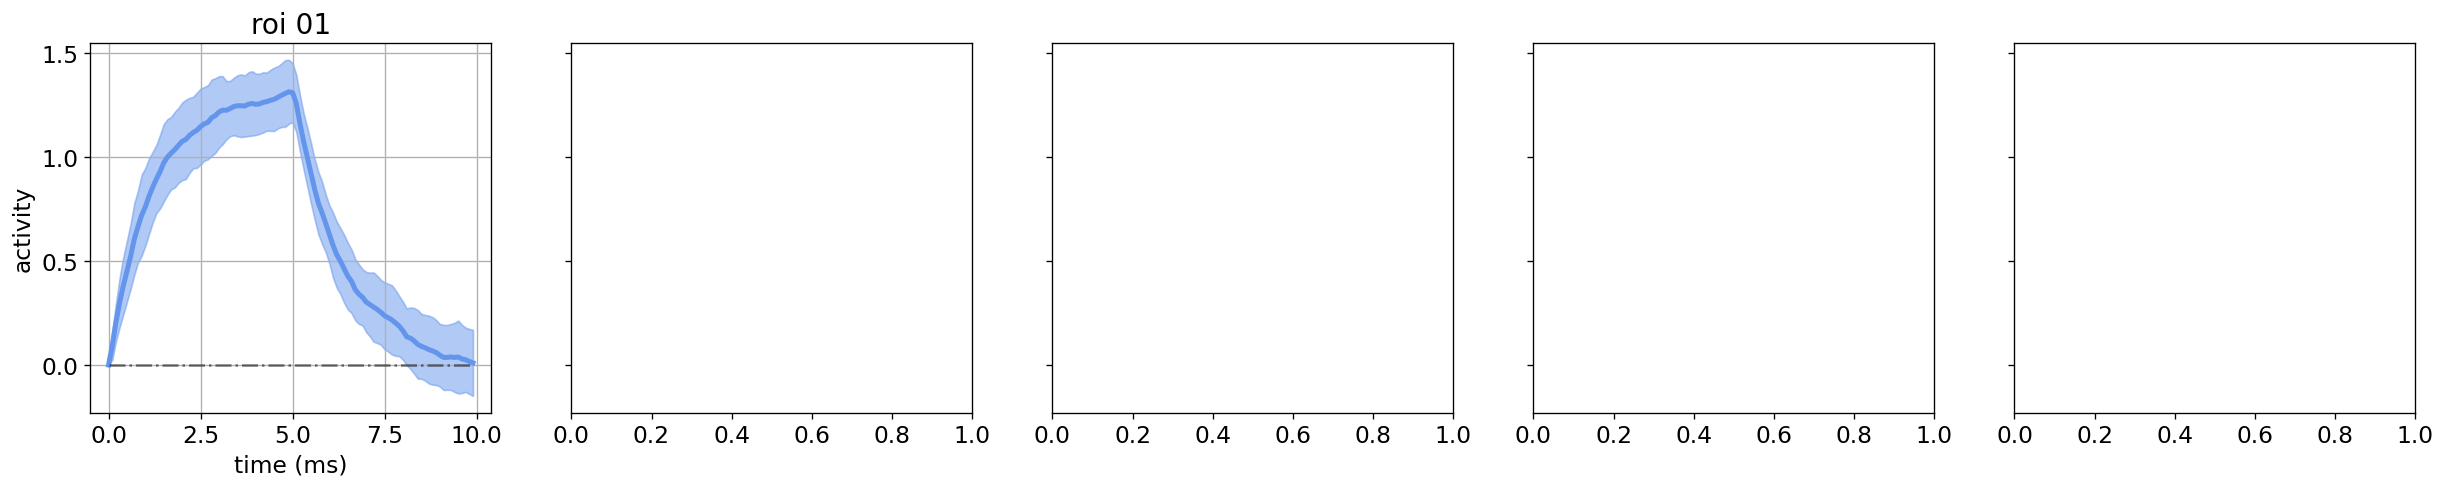

In [7]:
args.subplot_layout = 'row-col'
plot_utils.plot_roi_time_series(
    args, 
    out_dicts,
)

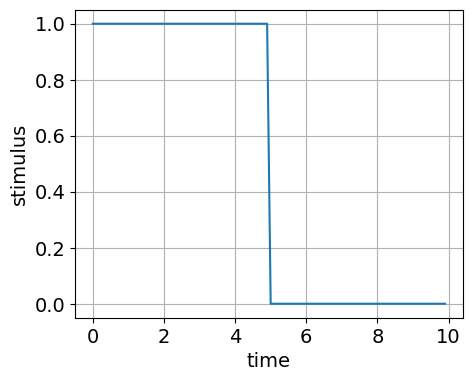

In [8]:
def u_fun(t):
    return args.Iamp * (np.mod(t, args.T) < args.tau)

x_train = [np.zeros((args.time.size, args.num_rois)) for _ in np.arange(args.num_runs)]
u_train = [np.zeros((args.time.size, 1)) for _ in np.arange(args.num_runs)]
for idx_run in np.arange(args.num_runs):
    x_train[idx_run] = out_dicts[f"run{idx_run:02}"]['x']
    u_train[idx_run] = u_fun(args.time)[:, None]

fig, axs = plt.subplots(1, 1, figsize=(5,4))
ax = axs
ax.plot(args.time, u_train[0])
ax.set_xlabel('time')
ax.set_ylabel('stimulus')
ax.grid(True)

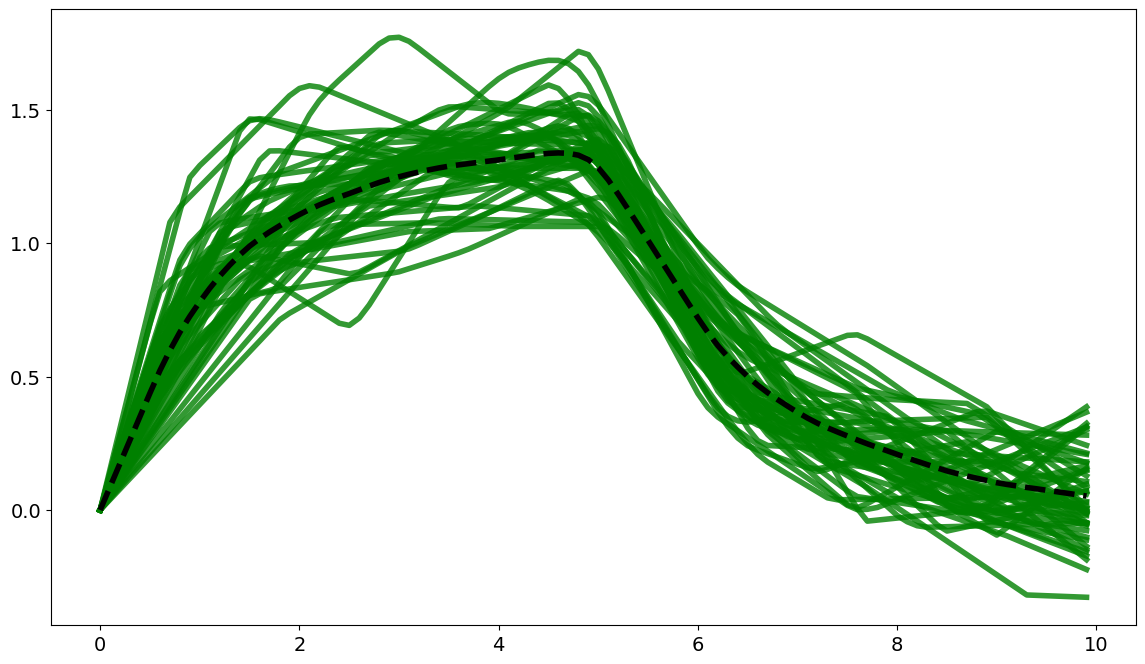

In [9]:
# trend filtered derivative gives smooth signals 
# that pass through the center of the noisy signals.

diffs = [
    ("PySINDy Finite Difference", ps.FiniteDifference()),
    ("Finite Difference", ps.SINDyDerivative(kind="finite_difference", k=1)),
    ("Smoothed Finite Difference", ps.SmoothedFiniteDifference()),
    (
        "Savitzky Golay",
        ps.SINDyDerivative(kind="savitzky_golay", left=0.5, right=0.5, order=3),
    ),
    ("Spline", ps.SINDyDerivative(kind="spline", s=1e-2)),
    ("Trend Filtered", ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-2)),
    ("Spectral", ps.SINDyDerivative(kind="spectral")),
    ("Spectral, PySINDy version", ps.SpectralDerivative()),
    ("Kalman", ps.SINDyDerivative(kind="kalman", alpha=0.05)),
]

x_tr = []
for idx, x in enumerate(x_train):
    xdiff = diffs[5][1]._differentiate(x, args.time)
    x_tr.append(np.concatenate([x[0], x[0] + np.cumsum(xdiff)[:-1]*args.dt]))

plot_kws = dict(linewidth=4)
fig, axs = plt.subplots(1, 1, figsize=(14, 8))
for idx, x in enumerate(x_tr):
    axs.plot(args.time, x, "g", alpha=0.8, **plot_kws)
axs.plot(args.time, np.mean(x_tr, axis=0), 'k--', **plot_kws)
# axs.legend()

### SINDy discovery

In [10]:
def discover_eqs(args, x_train, u_train, kwargs):
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=kwargs['threshold']),
        feature_library=ps.PolynomialLibrary(degree=kwargs['poly_order']),
        differentiation_method=ps.SINDyDerivative(
            kind="trend_filtered", order=0, alpha=1e-2),
        feature_names=['x', 'u'],
    )
    model.fit(
        x=x_train, 
        t=args.dt, 
        u=u_train, 
        multiple_trajectories=True,
        library_ensemble=True,
    )
    model.print()

    # simulate
    x_test = np.mean(x_train, axis=0)
    x_sim = model.simulate(
        x0=x_test[0],
        t=args.time,
        u=u_fun,
    )

    # predicted vs empirical time series: 
    # 1.0 (perfect predictions) or 0.0 (imperfect predictions)
    r2 = skl.metrics.r2_score(x_test, x_sim)
    print(f"R2: {r2}")

    return x_sim

In [11]:
# fit
args.kwargs_list = [
    {'poly_order':1, 'threshold':0.0},
    {'poly_order':2, 'threshold':0.0},
    # {'poly_order':3, 'threshold':0.1},
    # {'poly_order':4, 'threshold':0.1},
]
x_sim = [None for _ in range(len(args.kwargs_list))]
for idx_model, kwargs in enumerate(args.kwargs_list):
    print(f"model {idx_model+1}")
    x_sim[idx_model] = discover_eqs(
        args, 
        x_train, 
        u_train, 
        kwargs=args.kwargs_list[idx_model],
    )
    print(f"--------")
x_test = np.mean(x_train, axis=0)

model 1


(x)' = -0.592 x + 0.847 u
R2: 0.9698992358331882
--------
model 2
(x)' = -0.094 1 + -0.422 x + 0.518 u + -0.265 x u + 0.518 u^2
R2: 0.9723255292940376
--------


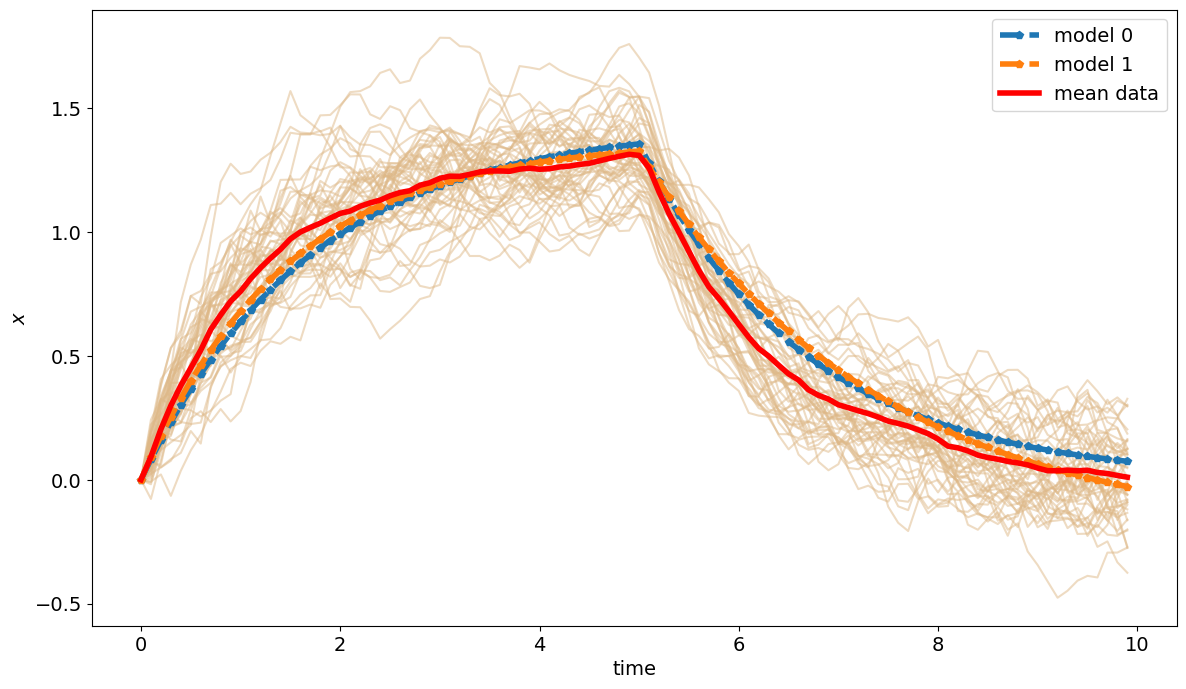

In [12]:
plot_kws = dict(linewidth=4)

fig, axs = plt.subplots(1, 1, figsize=(14, 8))
for idx, x in enumerate(x_train):
    axs.plot(args.time, x, c='burlywood', alpha=0.5, )
for idx_model, x_s in enumerate(x_sim):
    axs.plot(args.time, x_s, 'p--', label=f"model {idx_model:01}", **plot_kws)
axs.plot(args.time, x_test[:, 0], "r", label="mean data", **plot_kws)
axs.legend()
axs.set(xlabel="time", ylabel="$x$")
fig.show()

choose the model with least order/coefficients

## linear sde
2 nodes

$$
\begin{aligned}
\frac{d}{dt} x_1 &= -A x_1 + u \\
\frac{d}{dt} x_2 &= -A x_2 + x_1
\end{aligned}
$$

### synthetic data

In [13]:
args.num_rois = 2
network = 1 - np.eye(args.num_rois)
network[0, 1] = 0.0
# network[1, 0] = 0.0
print(network)

eng = matlab.engine.start_matlab()
model_path = f"{bdmodels_dir}"
model = eng.simulate_linear_sde_model

args.num_runs = 50
in_dicts = {
    f"run{idx_run:02}" : None
    for idx_run in range(args.num_runs)
}
out_dicts = copy.deepcopy(in_dicts)

args.dt = 0.1
args.time_end = 10
args.time_span = [0, args.time_end]
args.time = np.arange(0, args.time_end, args.dt)

args.stimulus = np.array([[1.0], [0.0]])
args.Iamp = 1.0
args.tau = 5.0
args.T = 25.0

in_dict = {}
in_dict['A'] = matlab.double(np.array([[0.5], [0.5]]))
in_dict['B'] = 1.0
in_dict['Iamp'] = args.Iamp
in_dict['tau'] = args.tau
in_dict['T'] = args.T
in_dict['tspan'] = matlab.double(args.time_span) 
in_dict['teval'] = matlab.double(args.time)
in_dict['s'] = matlab.double(args.stimulus)

for idx_run in tqdm(np.arange(args.num_runs)):
    in_dict['sigma'] = 0.2
    in_dict['x_init'] = matlab.double(np.array([[0.7], [0.0]])) #matlab.double(np.random.rand(args.num_rois, 1))
    in_dict['randn'] = np.random.normal(
        loc=0.0, 
        scale=1.0, 
        size=(args.num_rois, args.time.size),
    )
    in_dict['W'] = network
    in_dicts[f"run{idx_run:02}"] = copy.deepcopy(in_dict)

    out_dict = ts_sim_utils.simulate(eng, model_path, model, in_dict)

    out_dicts[f"run{idx_run:02}"] = copy.deepcopy(out_dict)

eng.quit()

[[0. 0.]
 [1. 0.]]


100%|██████████| 50/50 [00:17<00:00,  2.88it/s]


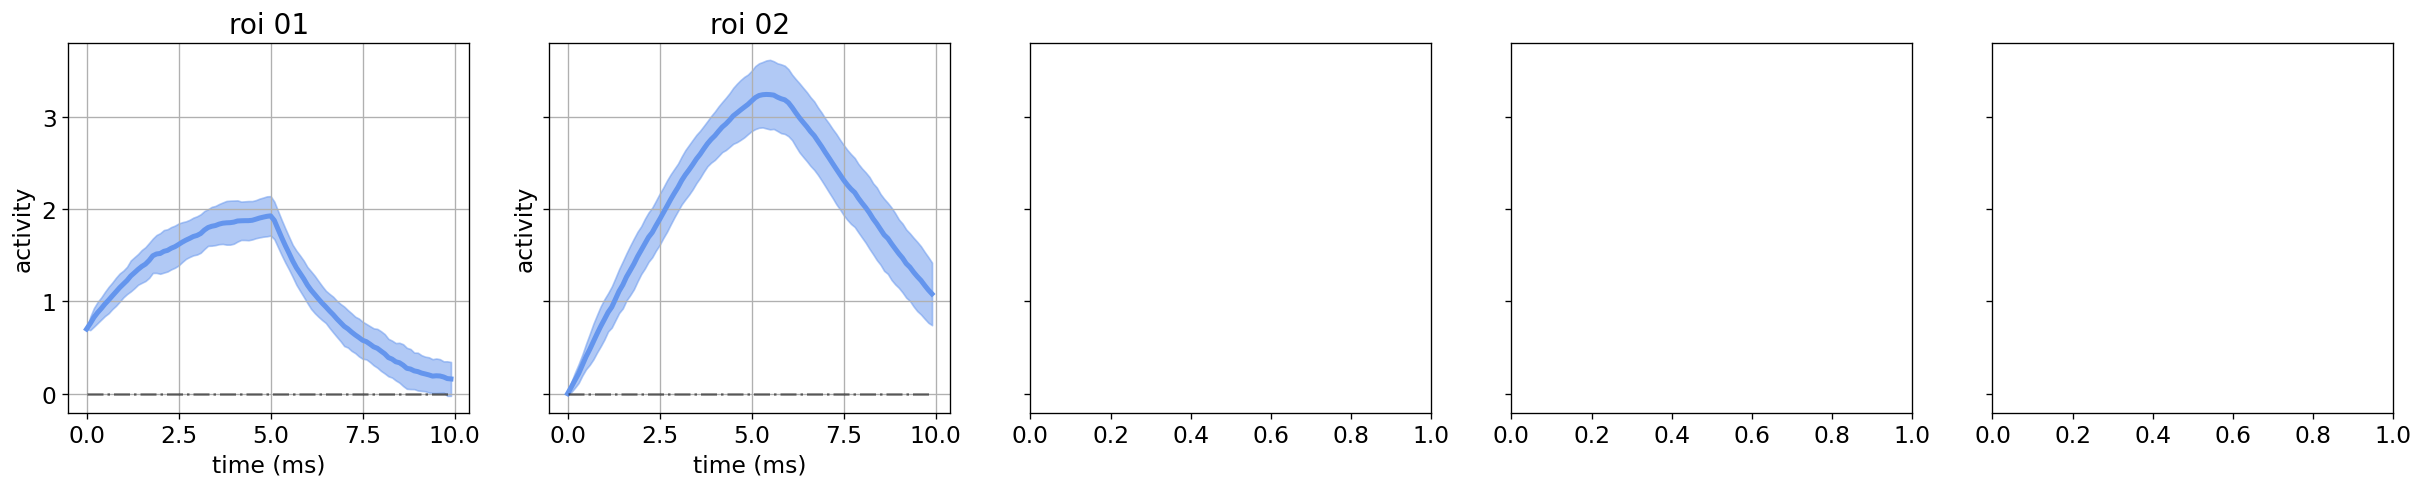

In [14]:
args.subplot_layout = 'row-col'
plot_utils.plot_roi_time_series(
    args, 
    out_dicts,
)

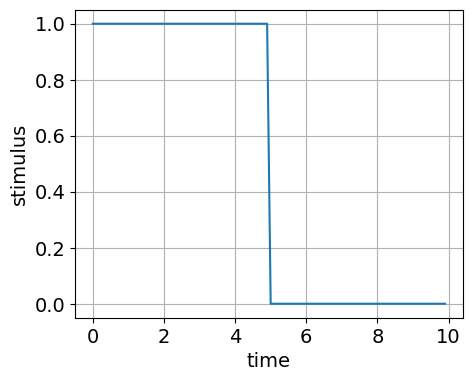

In [15]:
def u_fun(t):
    return args.Iamp * (np.mod(t, args.T) < args.tau)

x_train = [np.zeros((args.time.size, args.num_rois)) for _ in np.arange(args.num_runs)]
u_train = [np.zeros((args.time.size, 1)) for _ in np.arange(args.num_runs)]
for idx_run in np.arange(args.num_runs):
    x_train[idx_run] = out_dicts[f"run{idx_run:02}"]['x']
    u_train[idx_run] = u_fun(args.time)[:, None]

fig, axs = plt.subplots(1, 1, figsize=(5,4))
ax = axs
ax.plot(args.time, u_train[0])
ax.set_xlabel('time')
ax.set_ylabel('stimulus')
ax.grid(True)

In [16]:
def discover_eqs(args, x_train, u_train, kwargs):
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=kwargs['threshold']),
        feature_library=ps.PolynomialLibrary(degree=kwargs['poly_order']),
        differentiation_method=ps.SINDyDerivative(
            kind="trend_filtered", order=0, alpha=1e-2),
        feature_names=['x1', 'x2', 'u'],
    )
    model.fit(
        x=x_train, 
        t=args.dt, 
        u=u_train, 
        multiple_trajectories=True,
        library_ensemble=True,
        ensemble=False,
    )
    model.print()

    # simulate
    x_test = np.mean(x_train, axis=0)
    x_sim = model.simulate(
        x0=x_test[0],
        t=args.time,
        u=u_fun,
    )

    # predicted vs empirical time series: 
    # 1.0 (perfect predictions) or 0.0 (imperfect predictions)
    r2 = skl.metrics.r2_score(x_test, x_sim)
    print(f"R2: {r2}")

    return x_sim

In [17]:
# fit
args.kwargs_list = [
    {'poly_order':1, 'threshold':0.05},
    {'poly_order':2, 'threshold':0.1},
    # {'poly_order':3, 'threshold':0.1},
    # {'poly_order':4, 'threshold':0.1},
]
x_sim = [None for _ in range(len(args.kwargs_list))]
for idx_model, kwargs in enumerate(args.kwargs_list):
    print(f"model {idx_model+1}")
    x_sim[idx_model] = discover_eqs(
        args, 
        x_train, 
        u_train, 
        kwargs=args.kwargs_list[idx_model],
    )
    print(f"--------")
x_test = np.mean(x_train, axis=0)

model 1


(x1)' = 0.108 1 + -0.195 x2 + 0.474 u
(x2)' = -0.547 1 + 0.170 x1 + 0.929 u
R2: 0.8769959094884987
--------
model 2
(x1)' = 0.261 1 + -0.258 x2 + 0.281 x1 u
(x2)' = -0.422 1 + -13067414992.571 u + -0.127 x2 u + 13067414993.858 u^2
R2: 0.9715591092113263
--------


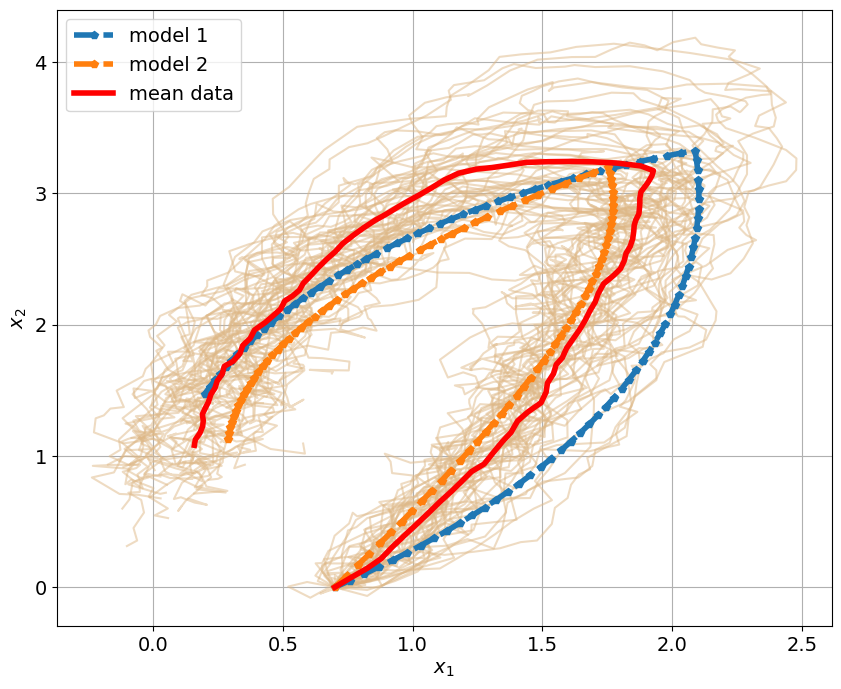

In [18]:
plot_kws = dict(linewidth=4)

fig, axs = plt.subplots(1, 1, figsize=(10, 8))
for idx, x in enumerate(x_train):
    axs.plot(x[:, 0], x[:, 1], c='burlywood', alpha=0.5, )
for idx_model, x_s in enumerate(x_sim):
    axs.plot(x_s[:, 0], x_s[:, 1], 'p--', label=f"model {idx_model+1:01}", **plot_kws)
axs.plot(x_test[:, 0], x_test[:, 1], "r", label="mean data", **plot_kws)
axs.legend()
axs.set(xlabel="$x_1$", ylabel="$x_2$")
axs.grid(True)
fig.show()
